In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from binarytree import tree,Node
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
import copy

In [18]:
df=pd.read_csv("train.csv")

In [19]:
X=df.drop(['left'],axis=1)
Y=df['left']
X = pd.concat([X,pd.get_dummies(X['sales'], prefix='sales')],axis=1)
X = pd.concat([X,pd.get_dummies(X['salary'], prefix='salary')],axis=1)
X.drop(['sales','salary'],axis=1, inplace=True)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)
X_Original_train=copy.deepcopy(X_train)
X_train = pd.concat([X_train,Y_train],axis=1)
X_Original_test=copy.deepcopy(X_test)
eps = np.finfo(float).eps
# X_train
depthListtrain={}
depthListtest={}

In [21]:
def find_overall_entropy(X_train):
    output=X_train.keys()[-1]
    target_value_list=X_train[output].unique()
    entropy=0
    for value in target_value_list:
        frac = float(X_train[output].value_counts()[value])/(len(X_train[output])+eps)
        entropy+=-frac*np.log2(frac+eps)
    return entropy

In [22]:
def find_attr_entropy(X_train,attr):
    if X_train.empty:
        return
    output=X_train.keys()[-1]
    target_value_list=X_train[output].unique()
    current_value_list=X_train[attr].unique()
    final_entropy=0
    den=1
    for cur_value in current_value_list:
        entropy=0
        for value in target_value_list:
            num = len(X_train[attr][X_train[attr] == cur_value][X_train[output] == value])
            den = len(X_train[attr][X_train[attr] == cur_value])
            frac=num/(den+eps)
            entropy+=-frac*np.log2(frac+eps)
        frac2=float(den)/len(X_train)
        final_entropy+=-frac2*entropy
    return final_entropy

In [23]:
def get_subdataframeNum1(X_train,node,value):
    if X_train.empty:
        return
    return X_train[X_train[node] < value].reset_index(drop=True)

In [24]:
def get_subdataframeNum2(X_train,node,value):
    if X_train.empty:
        return
    return X_train[X_train[node] >= value].reset_index(drop=True)

In [25]:
storemidpoint={}
storemidpoint.clear()
numeric_features = ['number_project','last_evaluation','satisfaction_level','average_montly_hours','time_spend_company']
for feature in numeric_features:
    IGMax=0
    midmax=0
    prev=None
    X_train.sort_values(feature,inplace=True)
    for index,row in X_train.iterrows():
        if prev is not None:
            if prev['left']!=row['left']:
                mid=(float(prev[feature])+float(row[feature]))/2
    #             print mid
                subtable1=get_subdataframeNum1(X_train,feature,mid)
                subtable2=get_subdataframeNum2(X_train,feature,mid)
                firstentropy=0
                secondentropy=0
                if subtable1.empty:
                    firstentropy=0
                else:
                    frac1=float(len(subtable1))/len(X_train)
                    firstentropy = frac1*find_overall_entropy(subtable1)
                if subtable2.empty:
                    secondentropy=0
                else:
                    frac2=float(len(subtable2))/len(X_train)
                    secondentropy = frac2*find_overall_entropy(subtable2)
                
                entropy1=find_overall_entropy(X_train)
                entropy2=firstentropy+secondentropy
                ig=abs(entropy1)-abs(entropy2)
    #             print ig
                if ig > IGMax:
                    IGMax=ig
                    midmax=mid

        prev=row
    storemidpoint[feature]=midmax
    for index,row in X_train.iterrows():
        if float(row[feature])>=midmax:
            X_train.at[index,feature]=1
        else:
            X_train.at[index,feature]=0
# print IGMax,midmax

In [26]:
def find_best_node(X_train):
    information_gain=[]
    for attr in X_train.keys()[:-1]:
        information_gain.append(find_overall_entropy(X_train)+find_attr_entropy(X_train,attr))
    return X_train.keys()[:-1][np.argmax(information_gain)]

In [27]:
def get_subdataframe(X_train,node,value):
    return X_train[X_train[node] == value].reset_index(drop=True)

In [28]:
class nodestruct:
    def __init__(self, value, pos=0, neg=0, left=None, right=None):
        self.value=value
        self.positive=pos
        self.negative=neg
        self.left=left
        self.right=right

In [29]:
def build_tree(X_train,depth):
    
    if len(X_train.columns)==1:
        return 
    output=X_train.keys()[-1]
    node = find_best_node(X_train)
    
    root=nodestruct(node)
#     print root.value

    outputValue,counts = np.unique(X_train[output],return_counts=True)                        
    
    if len(counts)<=1:
        if outputValue[0]==0:
            root.negative=counts[0]
        else:
            root.positive=counts[0]
    else:
        if outputValue[0]==0:
            root.negative=counts[0]
        else:
            root.positive=counts[0]
        if outputValue[1]==0:
            root.negative=counts[1]
        else:
            root.positive=counts[1]
            
        if depth==0:
            return root

        attValue=X_train[node].unique()
        for val in attValue:

            subdataframe = get_subdataframe(X_train,node,val)                     
            subdataframe=subdataframe.drop([node],axis=1)
            outputValue,counts = np.unique(subdataframe[output],return_counts=True)                        
            if len(counts)<=1:
                pass
            else:
                if val == 1:
                    root.right = build_tree(subdataframe,depth-1)
                else:
                    root.left = build_tree(subdataframe,depth-1)

    return root

In [30]:
depth=2
while depth<21:
                
    rootNode=build_tree(X_train,depth)
    # print rootNode.value
    # print rootNode.left.value
    # print rootNode.right.value

#     print storemidpoint

    def testing(X_test,root):

        if root.left == None and root.right == None:
            if root.positive>root.negative:
                y_pred.append(1)
            else:
                y_pred.append(0)
            return

        j = root.value
        if j in X_test:
            if X_test[j] == 1:
                if root.right==None:
                    if root.positive>root.negative:
                        y_pred.append(1)
                    else:
                        y_pred.append(0)
                else:
                    testing(X_test,root.right)
            else:
                if root.left==None:
                    if root.positive>root.negative:
                        y_pred.append(1)
                    else:
                        y_pred.append(0)
                else:
                    testing(X_test,root.left)
        else:
            if root.left==None:
                if root.positive>root.negative:
                    y_pred.append(1)
                else:
                    y_pred.append(0)
            else:
                testing(X_test,root.left)

    y_pred=[]
#     rootNode=build_tree(X_train,depth)
    # X_test1 = pd.read_csv("sample_test.csv")
    # X_test1 = pd.concat([X_test1,pd.get_dummies(X_test1['sales'], prefix='sales')],axis=1)
    # X_test1 = pd.concat([X_test1,pd.get_dummies(X_test1['salary'], prefix='salary')],axis=1)
    # X_test1.drop(['sales','salary'],axis=1, inplace=True)

    X_train1=copy.deepcopy(X_Original_train)
    X_test1=copy.deepcopy(X_Original_test)
    
    numeric_features = ['number_project','last_evaluation','satisfaction_level','average_montly_hours','time_spend_company']
    for feature in numeric_features:
        for index,row in X_test1.iterrows():
            if float(row[feature]) >= storemidpoint[feature]:
                X_test1.at[index,feature]=1
            else:
                X_test1.at[index,feature]=0
        
    for feature in numeric_features:
        for index,row in X_train1.iterrows():
            if float(row[feature]) >= storemidpoint[feature]:
                X_train1.at[index,feature]=1
            else:
                X_train1.at[index,feature]=0

    for index,row in X_test1.iterrows():
        testing(row,rootNode)

#     print accuracy_score(Y_test, y_pred)
#     print "Testing Data-----------------------------------------"
    depthListtest[depth] = 1-accuracy_score(Y_test, y_pred)
#     print depthListtest
#     print confusion_matrix(Y_test,y_pred)
#     print classification_report(Y_test,y_pred)
#     print accuracy_score(Y_test, y_pred)
    del y_pred[:]

#     convert_to_binary(X_train1)
    
    for index,row in X_train1.iterrows():
        testing(row,rootNode)

#     print accuracy_score(Y_test, y_pred)
#     print "Training Data--------------------------------------------"
    depthListtrain[depth] = 1-accuracy_score(Y_train, y_pred)
#     print depthListtrain
#     print confusion_matrix(Y_train,y_pred)
#     print classification_report(Y_train,y_pred)
#     print accuracy_score(Y_train, y_pred)
    del y_pred[:]

    # print y_pred
    
#     print depthList
    depth=depth+2

Text(0.5,1,'depth vs error')

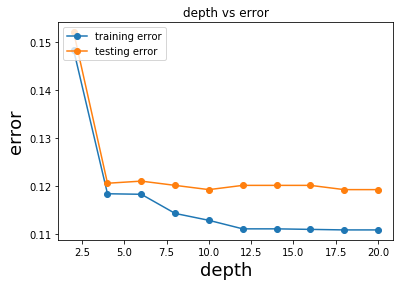

In [31]:
fig, ax = plt.subplots()
x_axis = [i for i in xrange(2,21,2)]
ax.plot(x_axis, depthListtrain.values(), label="training error",marker='o')
ax.plot(x_axis, depthListtest.values(), label="testing error",marker='o')
ax.legend(loc=2) # upper left corner
ax.set_xlabel("depth", fontsize=18)
ax.set_ylabel("error", fontsize=18)
ax.set_title('depth vs error')

In [32]:
modelTrain = DecisionTreeClassifier()
modelTrain.fit(X_Original_train,Y_train)
Y_predict=modelTrain.predict(X_Original_test)
print confusion_matrix(Y_test,Y_predict)
print classification_report(Y_test,Y_predict)
print accuracy_score(Y_test, Y_predict)

[[1672   28]
 [  29  519]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1700
           1       0.95      0.95      0.95       548

   micro avg       0.97      0.97      0.97      2248
   macro avg       0.97      0.97      0.97      2248
weighted avg       0.97      0.97      0.97      2248

0.974644128113879
